<a href="https://colab.research.google.com/github/omkar-salunke/Trading_algos/blob/main/Strategy_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Importing data 
!git clone https://github.com/omkar-salunke/Trading_algos.git

Cloning into 'Trading_algos'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [ ]:

# from google.colab import files
# zip=files.download("/content/Trading_algos/Data_NSE.zip")
# # Data taken from kaggle https://www.kaggle.com/rohanrao/nifty50-stock-market-data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import zipfile
with zipfile.ZipFile("/content/Trading_algos/Data_NSE.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Trading_algos")

In [36]:
!pip install ta
# Install backtesting infrastructure
# https://pypi.org/project/Backtesting/
!pip install backtesting
!apt-get install nodejs -y
!npm install -g --unsafe-perm ijavascript
!ijsinstall --install=global


  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=265d56a0087c41bd49c315d58b05aea022eda8fe178a85a9b3740bb254244418
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta
     |████████████████████████████████| 184kB 13.5MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.1-cp37-none-any.whl size=173832 sha256=d0d3f2edfb72be64b77efee180a6343b2de4574f2451c32408ff5bc8775da5f6
  Stored in directory: /root/.cache/pip/wheels/df/f7/2c/3243474df133eaf7feaba41d1f44f7d7727c264385a59927aa
Successfully built backtesting
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libc-ares2 nodejs-doc
The following NEW packages will be installed:
  libc-ares2 nodejs nodejs-doc
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 5,585 kB of archives.
After this operation, 24

In [45]:
# Preprocess Open, High, Low, Close (OHLC) data for Nifty index from 2009 to 2020
import pandas as pd
stock_data = pd.read_csv('/content/Trading_algos/BAJAJ-AUTO.csv');
stock_data.drop(columns=['Series','Symbol','Prev Close', 'VWAP', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'], inplace=True)
stock_data.Date= pd.to_datetime(stock_data.Date,format='%Y-%m-%d')
stock_data.set_index('Date',drop=True, inplace=True)
stock_data.columns

Index(['Open', 'High', 'Low', 'Last', 'Close', 'Volume'], dtype='object')

In [46]:
stock_data.head()

,Open,High,Low,Last,Close,Volume
Date,,,,,,
2008-05-26,898.00,898.0,551.35,600.25,604.75,3972485
2008-05-27,624.70,639.0,580.30,595.50,593.15,1751063
2008-05-28,561.65,621.9,561.65,605.10,608.15,1652355
2008-05-29,619.40,619.4,576.00,600.00,599.45,669269
2008-05-30,605.40,607.0,538.00,576.25,571.70,1262117


In [47]:
# Backtest a simple EMA -> SMA crossover strategy on above data

import backtesting
backtesting.set_bokeh_output(notebook=True)
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

import pandas as pd
import ta.trend as tr


# BOKEH_RESOURCES=inline
class EmaSmaCross(Strategy):
    def init(self):
      
      cp = pd.Series(self.data.Close)
      
      self.ema1 = self.I(tr.ema_indicator,close=cp, window=20);
      self.ema2 = self.I(tr.sma_indicator,close=cp, window=50);
      self.ema3 = self.I(tr.sma_indicator,close=cp, window=200)
        

    def next(self):
      # Buy or sell on ema -> sma cross over
      # Have a 200 pts stop loss for long trades and 130 points for short trades
      if crossover(self.ema1, self.ema2):
        self.buy(sl=self.data.High-200)
      elif crossover(self.ema2, self.ema1):
        self.sell(sl=self.data.Low+130)
      elif crossover(self.ema2, self.ema3):
        self.sell(sl=self.data.Low+100)     

bt = Backtest(stock_data, EmaSmaCross, commission=.002,cash=1000000,
              exclusive_orders=True)
# Run the backtest
stats = bt.run()
 
# Print the performance metrics for this strategy 
print(stats)

# Plot the price movements, trades and other meta-data such as drawdown etc.
bt.plot(resample=True);

Start                     2008-05-26 00:00:00
End                       2021-04-30 00:00:00
Duration                   4722 days 00:00:00
Exposure Time [%]                     58.2761
Equity Final [$]                       555060
Equity Peak [$]                   1.01098e+06
Return [%]                            -44.494
Buy & Hold Return [%]                  533.94
Return (Ann.) [%]                    -4.52727
Volatility (Ann.) [%]                 18.0734
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                     -62.759
Avg. Drawdown [%]                    -24.0245
Max. Drawdown Duration     4400 days 00:00:00
Avg. Drawdown Duration     1472 days 00:00:00
# Trades                                   74
Win Rate [%]                          29.7297
Best Trade [%]                        21.1841
Worst Trade [%]                      -15.7654
Avg. Trade [%]                    

**Hammer Candle backtesting**

In [23]:
df= pd.read_csv('/content/Trading_algos/CIPLA.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2021-04-26,CIPLA,EQ,935.6,935.60,940.0,902.15,907.95,905.40,914.11,10255697,9.374885e+14,161321.0,3451318.0,0.3365
2021-04-27,CIPLA,EQ,905.4,913.00,919.5,901.00,911.20,912.40,909.22,5669049,5.154420e+14,120188.0,1126288.0,0.1987
2021-04-28,CIPLA,EQ,912.4,914.35,918.0,902.95,906.25,910.20,909.94,7251009,6.597970e+14,134413.0,1772739.0,0.2445
2021-04-29,CIPLA,EQ,910.2,911.95,917.4,904.00,906.00,906.50,910.22,4953091,4.508421e+14,88604.0,1122534.0,0.2266
2021-04-30,CIPLA,EQ,906.5,900.75,921.0,900.75,910.00,910.35,911.47,6459737,5.887824e+14,121466.0,2004555.0,0.3103


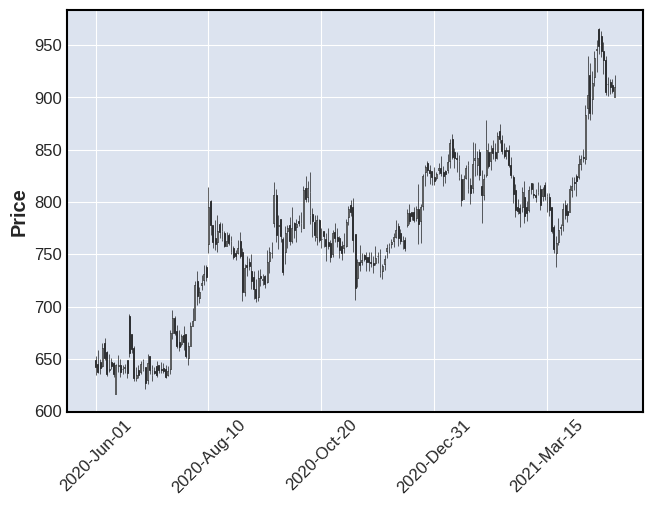

In [24]:
# candlestick patterns do all than make pretty
# Visualise first
import mplfinance as mpf
# only considering the recent data
recent = df[df.index > '2020-05-29']
mpf.plot(recent,type='candle')

In [25]:
df.drop(['Symbol','Series','Prev Close','Trades','Deliverable Volume','%Deliverble','Last','VWAP','Volume','Turnover'],inplace=True,axis=1)

In [26]:
import backtrader as bt
# Most of the code directly copied from the backtrader website********************************************
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].High
        self.dataopen = self.datas[0].Open
        self.datalow = self.datas[0].Low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

       
        if not self.position:
            if (((self.datahigh - self.datalow) > 3 * (self.dataopen - self.dataclose)) and((self.dataclose - self.datalow) / (.001 + self.datahigh - self.datalow) > 0.6) and ((self.dataopen - self.datalow) / (.001 + self.datahigh - self.datalow) > 0.6)):
                self.order = self.buy() 


        else:

            # Randomly selling after 3 timecyles...
            if len(self) >= (self.bar_executed + 3):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [27]:
import backtrader as bt
cerebro = bt.Cerebro()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
data = bt.feeds.PandasData(dataname=recent)
cerebro.adddata(data)
cerebro.addstrategy(TestStrategy)
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 10000.00
2020-06-01, Close, 642.50
2020-06-02, BUY EXECUTED, 644.90
2020-06-02, Close, 637.60
2020-06-03, Close, 641.20
2020-06-04, Close, 660.55
2020-06-05, Close, 650.90
2020-06-05, SELL CREATE, 650.90
2020-06-08, SELL EXECUTED, 656.70
2020-06-08, Close, 635.10
2020-06-09, BUY EXECUTED, 638.90
2020-06-09, Close, 640.05
2020-06-10, Close, 642.95
2020-06-11, Close, 635.00
2020-06-12, Close, 643.60
2020-06-12, SELL CREATE, 643.60
2020-06-15, SELL EXECUTED, 643.00
2020-06-15, Close, 643.65
2020-06-16, BUY EXECUTED, 644.50
2020-06-16, Close, 637.80
2020-06-17, Close, 640.35
2020-06-18, Close, 642.05
2020-06-19, Close, 636.20
2020-06-19, SELL CREATE, 636.20
2020-06-22, SELL EXECUTED, 691.00
2020-06-22, Close, 655.95
2020-06-23, BUY EXECUTED, 674.00
2020-06-23, Close, 659.80
2020-06-24, Close, 631.20
2020-06-25, Close, 634.90
2020-06-26, Close, 634.90
2020-06-26, SELL CREATE, 634.90
2020-06-29, SELL EXECUTED, 637.00
2020-06-29, Close, 644.90
2020-06-30, BUY EXECUTE

**Running the same algorithm on all the stocks**

In [1]:
!pip install mplfinance
!pip install backtrader
import glob
import pandas as pd
import backtrader as bt

     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 419kB 24.3MB/s 


In [36]:
class Hammer_candle(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].High
        self.dataopen = self.datas[0].Open
        self.datalow = self.datas[0].Low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

       
        if not self.position:
            if (((self.datahigh - self.datalow) > 3 * (self.dataopen - self.dataclose)) and((self.dataclose - self.datalow) / (.001 + self.datahigh - self.datalow) > 0.6) and ((self.dataopen - self.datalow) / (.001 + self.datahigh - self.datalow) > 0.6)):
                self.order = self.buy() 


        else:

            # Randomly selling after 3 timecyles...
            if len(self) >= (self.bar_executed + 3):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [37]:

row=0
Summary_df=pd.DataFrame()
glued_data = pd.DataFrame()
for file_name in glob.glob('/content/Trading_algos/'+'*.csv'):
  if 'cerebro' in globals():
    del cerebro
  

  try:
    cerebro = bt.Cerebro()
    df= pd.read_csv(file_name, index_col='Date')
    df.index = pd.to_datetime(df.index) 
    df.drop(['Symbol','Series','Prev Close','Trades','Deliverable Volume','%Deliverble','Last','VWAP','Volume','Turnover'],inplace=True,axis=1)
    # For the period after specific date
    recent = df[df.index > '2020-05-29']
    # print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    intial_val=cerebro.broker.getvalue()
    
    data = bt.feeds.PandasData(dataname=recent)
    cerebro.adddata(data)
    cerebro.addstrategy(Hammer_candle)
    cerebro.run()
    final_val=cerebro.broker.getvalue()
    # print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    Summary_df.loc[row, 'stock_name'] = file_name.split("/")[-1]
    Summary_df.loc[row, 'intial_portfolio_val'] = intial_val
    Summary_df.loc[row, 'final_portfolio_val'] = final_val
    row+=1
  except Exception:
    pass
Summary_df

Streaming output truncated to the last 5000 lines.
2021-01-15, Close, 2857.30
2021-01-18, Close, 2873.00
2021-01-19, Close, 2883.50
2021-01-20, Close, 2881.55
2021-01-20, SELL CREATE, 2881.55
2021-01-21, SELL EXECUTED, 2896.00
2021-01-21, Close, 2926.60
2021-01-22, BUY EXECUTED, 2900.00
2021-01-22, Close, 2972.60
2021-01-25, Close, 2869.55
2021-01-27, Close, 2789.90
2021-01-28, Close, 2798.45
2021-01-28, SELL CREATE, 2798.45
2021-01-29, SELL EXECUTED, 2812.40
2021-01-29, Close, 2744.30
2021-02-01, BUY EXECUTED, 2777.00
2021-02-01, Close, 2842.85
2021-02-02, Close, 2904.85
2021-02-03, Close, 2916.90
2021-02-04, Close, 2963.45
2021-02-04, SELL CREATE, 2963.45
2021-02-05, SELL EXECUTED, 2973.20
2021-02-05, Close, 2932.15
2021-02-08, BUY EXECUTED, 2934.00
2021-02-08, Close, 2970.40
2021-02-09, Close, 2947.65
2021-02-10, Close, 2901.30
2021-02-11, Close, 2818.15
2021-02-11, SELL CREATE, 2818.15
2021-02-12, SELL EXECUTED, 2840.00
2021-02-12, Close, 2781.25
2021-02-15, BUY EXECUTED, 2796.00
2

In [38]:
Summary_df

,stock_name,intial_portfolio_val,final_portfolio_val
0,SBIN.csv,10000.0,10189.70
1,TCS.csv,10000.0,10585.65
2,RELIANCE.csv,10000.0,10545.25
3,UPL.csv,10000.0,10197.90
4,BAJFINANCE.csv,10000.0,12529.40
5,ASIANPAINT.csv,10000.0,10542.25
6,INFY.csv,10000.0,10461.15
7,JSWSTEEL.csv,10000.0,10476.45
8,CIPLA.csv,10000.0,10414.45
9,KOTAKBANK.csv,10000.0,10219.15


**Inverted Hammer Candle backtesting**

In [7]:
!pip install mplfinance
!pip install backtrader
import glob
import pandas as pd
import backtrader as bt

In [45]:
class Inverted_Hammer_candle_stick(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].High
        self.dataopen = self.datas[0].Open
        self.datalow = self.datas[0].Low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

       
        if not self.position:
            if (((self.datahigh - self.datalow) > 3 * (self.dataopen - self.dataclose)) and((self.datahigh - self.dataclose) / (.001 + self.datahigh - self.datalow) > 0.6) and ((self.datahigh - self.dataopen) / (.001 + self.datahigh - self.datalow) > 0.6)):
                self.order = self.buy() 


        else:

            # Randomly selling after 3 timecyles...
            if len(self) >= (self.bar_executed + 3):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [46]:
row=0
Summary_df=pd.DataFrame()
glued_data = pd.DataFrame()
for file_name in glob.glob('/content/Trading_algos/'+'*.csv'):
  if 'cerebro' in globals():
    del cerebro
  cerebro = bt.Cerebro()

  try:
    cerebro = bt.Cerebro()
    df= pd.read_csv(file_name, index_col='Date')
    df.index = pd.to_datetime(df.index) 
    df.drop(['Symbol','Series','Prev Close','Trades','Deliverable Volume','%Deliverble','Last','VWAP','Volume','Turnover'],inplace=True,axis=1)
    # For the period after specific date
    recent = df[df.index > '2020-05-29']
    # print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    intial_val=cerebro.broker.getvalue()
    
    data = bt.feeds.PandasData(dataname=recent)
    cerebro.adddata(data)
    cerebro.addstrategy(Inverted_Hammer_candle_stick)
    cerebro.run()
    final_val=cerebro.broker.getvalue()
    # print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    Summary_df.loc[row, 'stock_name'] = file_name.split("/")[-1]
    Summary_df.loc[row, 'intial_portfolio_val'] = intial_val
    Summary_df.loc[row, 'final_portfolio_val'] = final_val
    row+=1
  except Exception:
    pass

Streaming output truncated to the last 5000 lines.
2020-09-23, Close, 1047.25
2020-09-24, Close, 1030.40
2020-09-25, Close, 1044.00
2020-09-28, Close, 1054.20
2020-09-29, Close, 1062.55
2020-09-30, Close, 1078.60
2020-10-01, Close, 1106.95
2020-10-05, Close, 1114.35
2020-10-06, Close, 1144.10
2020-10-07, Close, 1162.25
2020-10-08, Close, 1191.80
2020-10-09, Close, 1233.55
2020-10-12, Close, 1213.65
2020-10-13, Close, 1198.45
2020-10-14, Close, 1211.50
2020-10-15, Close, 1169.25
2020-10-16, Close, 1199.35
2020-10-19, Close, 1203.55
2020-10-20, Close, 1223.95
2020-10-21, Close, 1246.70
2020-10-22, Close, 1233.30
2020-10-23, Close, 1235.80
2020-10-26, Close, 1210.90
2020-10-27, Close, 1233.10
2020-10-28, Close, 1209.60
2020-10-29, Close, 1187.20
2020-10-30, Close, 1183.55
2020-11-02, Close, 1215.25
2020-11-03, Close, 1247.95
2020-11-04, Close, 1257.40
2020-11-05, Close, 1269.20
2020-11-06, Close, 1307.65
2020-11-09, Close, 1340.55
2020-11-10, Close, 1393.65
2020-11-11, Close, 1389.95
2020

In [47]:
Summary_df

,stock_name,intial_portfolio_val,final_portfolio_val
0,SBIN.csv,10000.0,10000.0
1,TCS.csv,10000.0,10000.0
2,RELIANCE.csv,10000.0,10000.0
3,UPL.csv,10000.0,10000.0
4,BAJFINANCE.csv,10000.0,10000.0
5,ASIANPAINT.csv,10000.0,10000.0
6,INFY.csv,10000.0,10000.0
7,JSWSTEEL.csv,10000.0,10000.0
8,CIPLA.csv,10000.0,10000.0
9,KOTAKBANK.csv,10000.0,10000.0


In [49]:
class bull_dragon_fly(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].High
        self.dataopen = self.datas[0].Open
        self.datalow = self.datas[0].Low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

       
        if not self.position:
            if (((self.datahigh - self.datalow) > 3 * (self.dataopen - self.dataclose)) and (self.dataclose - self.datalow) > 0.8* (self.datahigh - self.datalow) and (self.dataopen - self.datalow) > 0.8*(self.datahigh - self.datalow)):
                self.order = self.buy() 


        else:

            # Randomly selling after 3 timecyles...
            if len(self) >= (self.bar_executed + 3):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [53]:
row=0
Summary_df=pd.DataFrame()
glued_data = pd.DataFrame()
for file_name in glob.glob('/content/Trading_algos/'+'*.csv'):
  if 'cerebro' in globals():
    del cerebro
  cerebro = bt.Cerebro()

  try:
    cerebro = bt.Cerebro()
    df= pd.read_csv(file_name, index_col='Date')
    df.index = pd.to_datetime(df.index) 
    df.drop(['Symbol','Series','Prev Close','Trades','Deliverable Volume','%Deliverble','Last','VWAP','Volume','Turnover'],inplace=True,axis=1)
    # For the period after specific date
    recent = df[df.index > '2020-05-31']
    # print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    intial_val=cerebro.broker.getvalue()
    
    data = bt.feeds.PandasData(dataname=recent)
    cerebro.adddata(data)
    cerebro.addstrategy(bull_dragon_fly)
    cerebro.run()
    final_val=cerebro.broker.getvalue()
    # print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    Summary_df.loc[row, 'stock_name'] = file_name.split("/")[-1]
    Summary_df.loc[row, 'intial_portfolio_val'] = intial_val
    Summary_df.loc[row, 'final_portfolio_val'] = final_val
    row+=1
  except Exception:
    pass

Streaming output truncated to the last 5000 lines.
2021-01-15, Close, 101.30
2021-01-18, Close, 98.30
2021-01-19, Close, 98.55
2021-01-20, Close, 98.30
2021-01-20, SELL CREATE, 98.30
2021-01-21, SELL EXECUTED, 98.20
2021-01-21, Close, 96.70
2021-01-22, BUY EXECUTED, 96.50
2021-01-22, Close, 95.70
2021-01-25, Close, 93.45
2021-01-27, Close, 91.40
2021-01-28, Close, 92.60
2021-01-28, SELL CREATE, 92.60
2021-01-29, SELL EXECUTED, 93.80
2021-01-29, Close, 93.25
2021-02-01, BUY EXECUTED, 95.80
2021-02-01, Close, 95.80
2021-02-02, Close, 98.80
2021-02-03, Close, 101.85
2021-02-04, Close, 103.60
2021-02-04, SELL CREATE, 103.60
2021-02-05, SELL EXECUTED, 104.50
2021-02-05, Close, 102.40
2021-02-08, BUY EXECUTED, 104.00
2021-02-08, Close, 104.10
2021-02-09, Close, 97.70
2021-02-10, Close, 96.75
2021-02-11, Close, 96.50
2021-02-11, SELL CREATE, 96.50
2021-02-12, SELL EXECUTED, 96.55
2021-02-12, Close, 95.10
2021-02-15, BUY EXECUTED, 95.55
2021-02-15, Close, 94.15
2021-02-16, Close, 95.60
2021-02

In [88]:
Summary_df

,stock_name,intial_portfolio_val,final_portfolio_val
0,SBIN.csv,10000.0,10189.70
1,TCS.csv,10000.0,10585.65
2,RELIANCE.csv,10000.0,10545.25
3,UPL.csv,10000.0,10197.90
4,BAJFINANCE.csv,10000.0,12529.40
5,ASIANPAINT.csv,10000.0,10542.25
6,INFY.csv,10000.0,10461.15
7,JSWSTEEL.csv,10000.0,10476.45
8,CIPLA.csv,10000.0,10414.45
9,KOTAKBANK.csv,10000.0,10219.15


In [89]:
Summary_all=Summary_df.sum()
print("Profit: "+str(Summary_all['final_portfolio_val'] - Summary_all['intial_portfolio_val']) +" for the period: "+str(recent.reset_index().loc[0,'Date'])+ " to "+str(recent.reset_index().loc[len(recent)-1,'Date']))


Profit: 25769.0 for the period: 2020-06-01 00:00:00 to 2021-04-30 00:00:00
